# **Final Project**

### Shelly Levy 318901550 and Adam Bublil 207271610



# **Data Import and Preprocessing**
In this section, we will import and preprocess the data, examine its distribution, and define useful functions that will be utilized later in the notebook.

# **Importing Libraries**







In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.optim import Adam
import torch.optim as optim
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score, 
    precision_score, recall_score, roc_auc_score, roc_curve, log_loss, 
    matthews_corrcoef, cohen_kappa_score
)
from sklearn.decomposition import PCA
from torchvision.transforms import RandomApply
from sklearn.utils import resample
import pandas as pd
import time
from collections import Counter, defaultdict
from sklearn.ensemble import IsolationForest
import imagehash
from sklearn.model_selection import train_test_split


C:\Users\adamb\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\adamb\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# **EDA**

In [2]:
def load_images_with_metadata(directory, label):
    images = []
    sizes = []
    formats = []
    color_modes = []
    
    for filename in os.listdir(directory):
        if any(filename.endswith(ext) for ext in ['jpg', 'jpeg', 'png', 'bmp']):
            img_path = os.path.join(directory, filename)
            try:
                with Image.open(img_path) as img:
                    formats.append(img.format)
                    color_modes.append(img.mode)
                    sizes.append(img.size)
                    img = img.convert('RGB')  # Convert to RGB
                    images.append((np.array(img), label))
            except IOError as e:
                print(f"Cannot process {filename}: {e}")
    
    return images, sizes, formats, color_modes

bike_directory = os.path.join(os.getcwd(), 'Car-Bike-Dataset/Bike')
car_directory = os.path.join(os.getcwd(), 'Car-Bike-Dataset/Car')

bike_images, bike_sizes, bike_formats, bike_modes = load_images_with_metadata(bike_directory, 'Bike')
car_images, car_sizes, car_formats, car_modes = load_images_with_metadata(car_directory, 'Car')

# Combine data
all_images = bike_images + car_images
all_sizes = bike_sizes + car_sizes
all_formats = bike_formats + car_formats
all_modes = bike_modes + car_modes
all_labels = ['Bike'] * len(bike_images) + ['Car'] * len(car_images)

C:\Users\adamb\anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [3]:
total_images = len(all_images)
print(f"Total number of images: {total_images}")

Total number of images: 3996


### Sizes of the images

In [4]:
unique_sizes = set(all_sizes)
print(f"Unique image sizes: {len(unique_sizes)}")

Unique image sizes: 429


### Formats

In [5]:
# Print if all images are jpg, png, or mixed
format_counts = Counter(all_formats)
print(f"Image format distribution: {format_counts}")

Image format distribution: Counter({'JPEG': 3969, 'PNG': 25, 'WEBP': 2})


### Distribution of Labels

Number of bike images: 1999
Number of car images: 1997


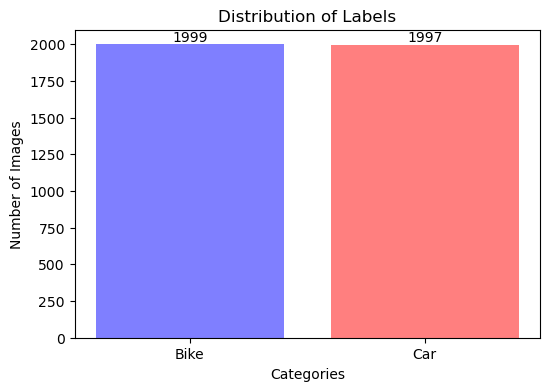

In [6]:
print(f"Number of bike images: {len(bike_images)}")
print(f"Number of car images: {len(car_images)}")

# Plot distribution of labels
plt.figure(figsize=(6,4))
plt.bar(['Bike', 'Car'], [len(bike_images), len(car_images)], color=['blue', 'red'],alpha=0.5)
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Labels')
for i in range(2):
    plt.text(i, [len(bike_images), len(car_images)][i], str([len(bike_images), len(car_images)][i]), ha='center', va='bottom')
plt.show()


### Images

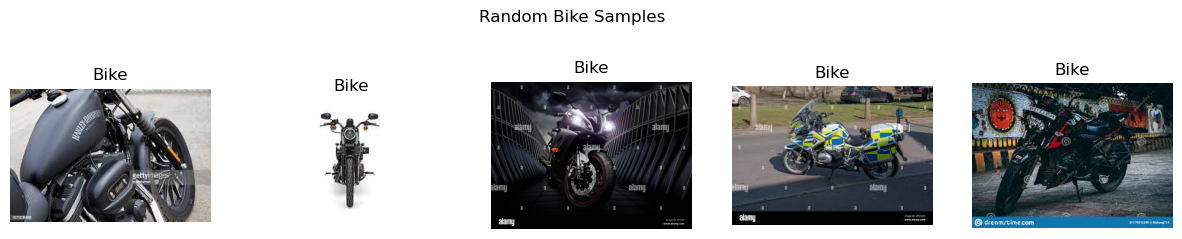

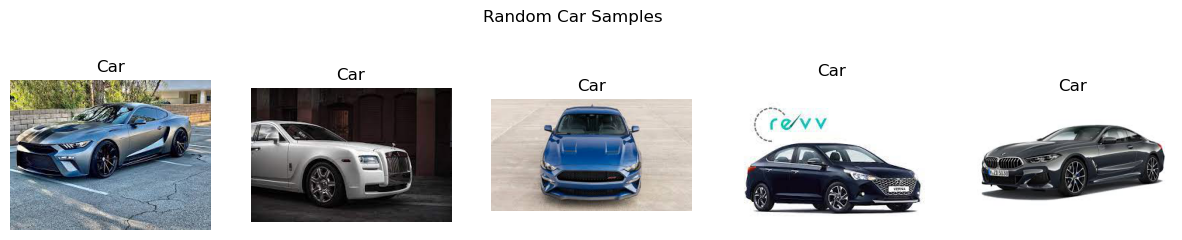

In [7]:
def show_random_samples(images, title, num_samples=5):
    samples = random.sample(images, min(num_samples, len(images)))
    plt.figure(figsize=(15,3))
    for i, (img, label) in enumerate(samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
    plt.suptitle(title)
    plt.show()

show_random_samples(bike_images, "Random Bike Samples")
show_random_samples(car_images, "Random Car Samples")

### Histogram of Image Sizes

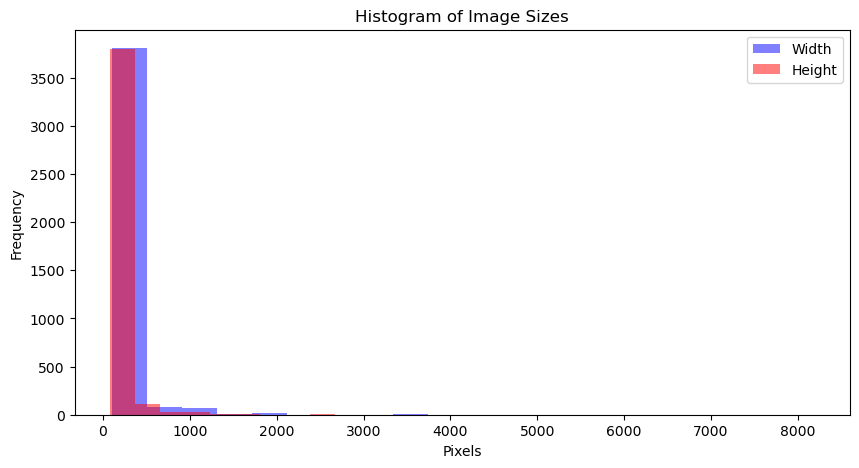

In [8]:
widths, heights = zip(*all_sizes)
plt.figure(figsize=(10,5))
plt.hist(widths, bins=20, alpha=0.5, label='Width', color='blue')
plt.hist(heights, bins=20, alpha=0.5, label='Height', color='red')
plt.xlabel('Pixels')
plt.ylabel('Frequency')
plt.title('Histogram of Image Sizes')
plt.legend()
plt.show()

### RGB vs Grayscale

In [9]:
# Print how many images are RGB and how many are grayscale
mode_counts = Counter(all_modes)
print(f"Image mode distribution (RGB vs Grayscale): {mode_counts}")

Image mode distribution (RGB vs Grayscale): Counter({'RGB': 3973, 'RGBA': 16, 'P': 7})


### Image Sharpness

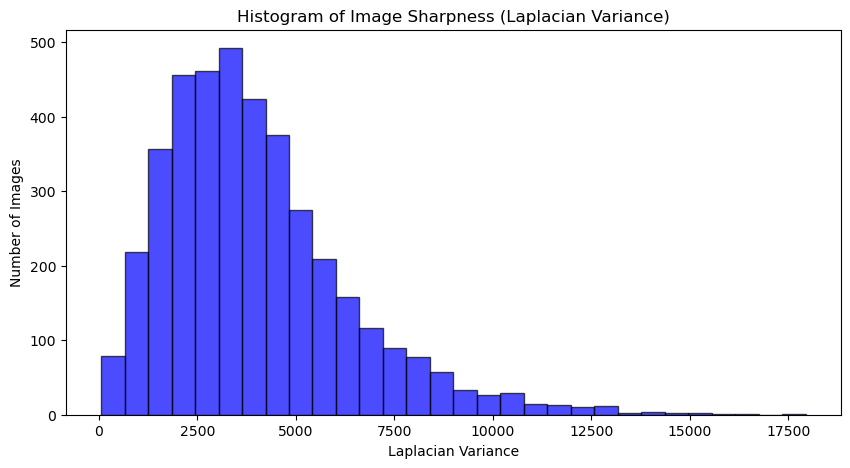

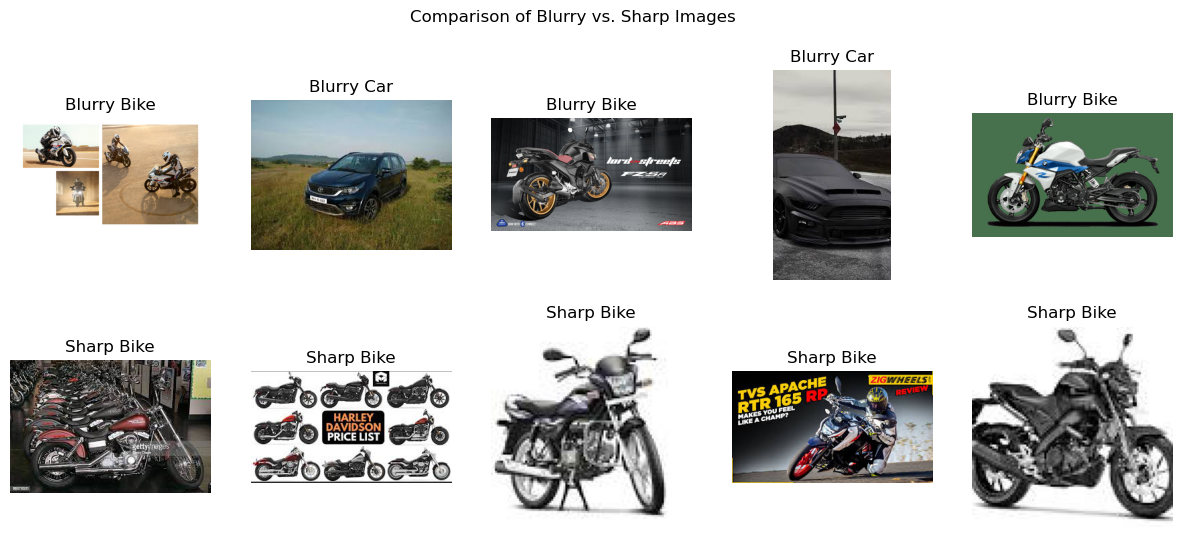

In [10]:
def compute_laplacian_variance(image):
    """Compute the variance of the Laplacian to assess image sharpness."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return laplacian.var()

# Compute Laplacian variance for all images
laplacian_variances = [compute_laplacian_variance(img) for img, _ in all_images]

# Plot histogram of Laplacian variances
plt.figure(figsize=(10, 5))
plt.hist(laplacian_variances, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Laplacian Variance")
plt.ylabel("Number of Images")
plt.title("Histogram of Image Sharpness (Laplacian Variance)")
plt.show()

# Select blurry and sharp images for visualization
threshold = np.percentile(laplacian_variances, 10)  # Define threshold for blur (10th percentile)
blurry_images = [img for img, var in zip(all_images, laplacian_variances) if var < threshold]
sharp_images = [img for img, var in zip(all_images, laplacian_variances) if var > np.percentile(laplacian_variances, 90)]

# Display sample blurry and sharp images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, (image, label) in enumerate(random.sample(blurry_images, min(5, len(blurry_images)))):
    axes[0, i].imshow(image)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Blurry {label}")

for i, (image, label) in enumerate(random.sample(sharp_images, min(5, len(sharp_images)))):
    axes[1, i].imshow(image)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Sharp {label}")

plt.suptitle("Comparison of Blurry vs. Sharp Images")
plt.show()

### Pixel Intensities

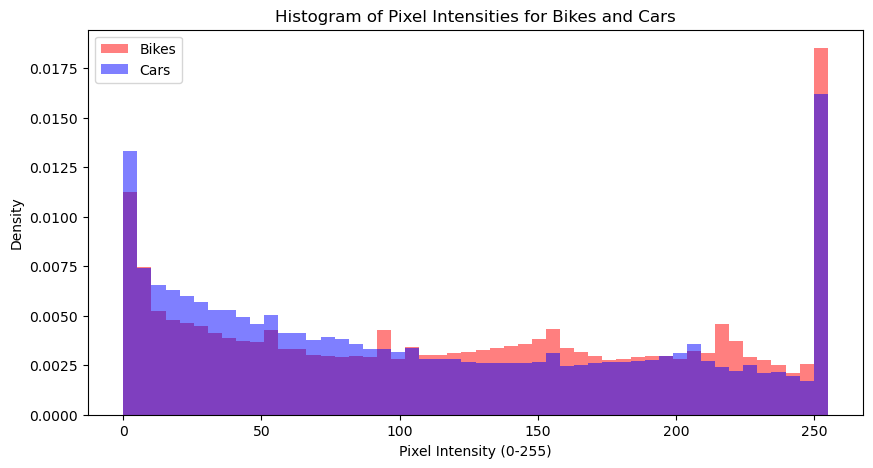

In [11]:
def compute_pixel_intensity(image):
    """Convert image to grayscale and return pixel intensities."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray.flatten()

# Compute pixel intensities for bikes and cars
bike_intensities = [compute_pixel_intensity(img) for img, label in all_images if label == 'Bike']
car_intensities = [compute_pixel_intensity(img) for img, label in all_images if label == 'Car']

# Flatten lists
bike_intensities = np.concatenate(bike_intensities) if bike_intensities else np.array([])
car_intensities = np.concatenate(car_intensities) if car_intensities else np.array([])

# Plot histograms
plt.figure(figsize=(10, 5))
plt.hist(bike_intensities, bins=50, color='red', alpha=0.5, label='Bikes', density=True)
plt.hist(car_intensities, bins=50, color='blue', alpha=0.5, label='Cars', density=True)
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Density")
plt.title("Histogram of Pixel Intensities for Bikes and Cars")
plt.legend()
plt.show()

### Brightness & Contrast Analysis

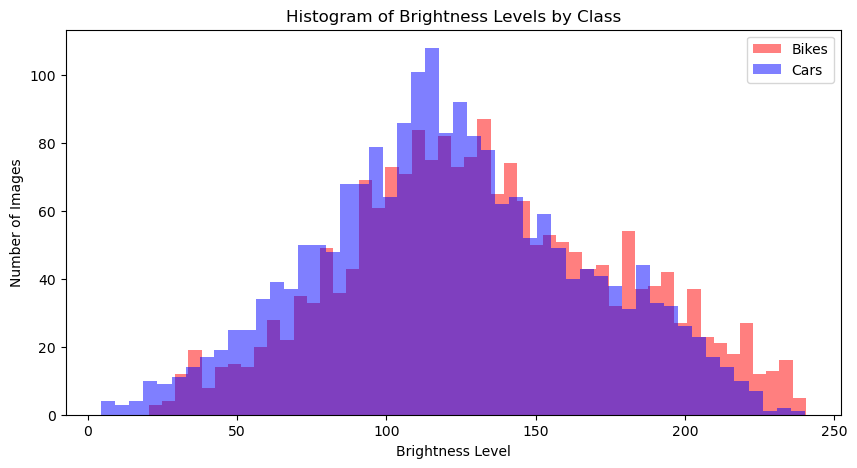

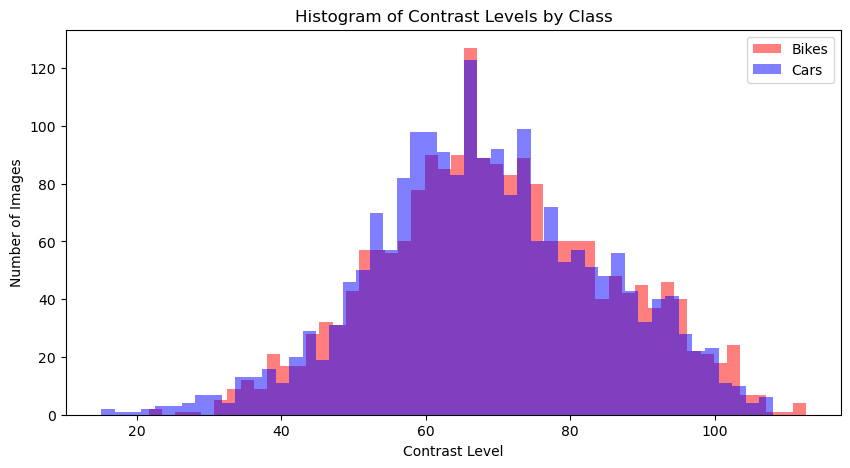

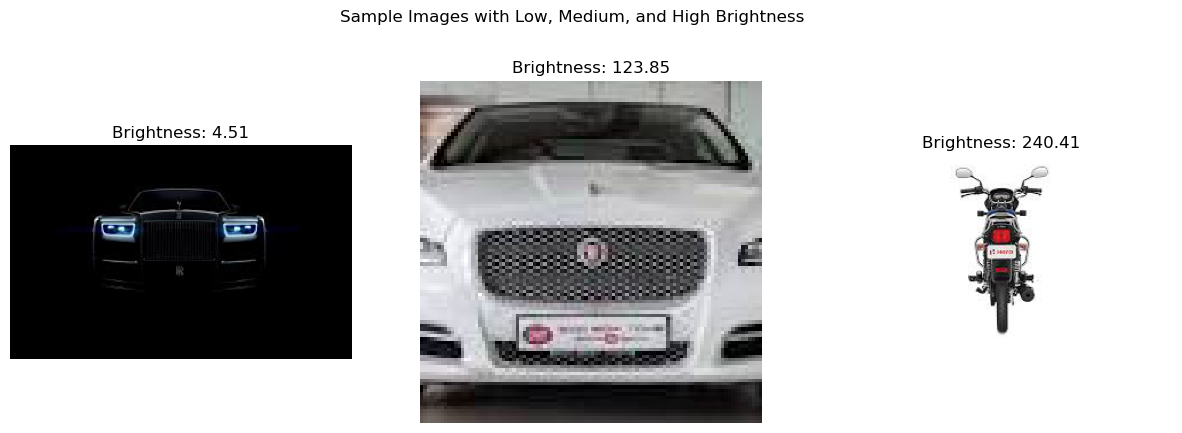

In [12]:
def compute_brightness_contrast(image):
    """Compute the mean brightness and contrast (std of pixel intensity) of a grayscale image."""
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    brightness = np.mean(gray)
    contrast = np.std(gray)
    return brightness, contrast

# Compute brightness and contrast for all images
brightness_contrast = [compute_brightness_contrast(img) for img, _ in all_images]
brightness_levels = [bc[0] for bc in brightness_contrast]
contrast_levels = [bc[1] for bc in brightness_contrast]

# Plot histogram of brightness levels
plt.figure(figsize=(10, 5))
plt.hist([brightness for brightness, label in zip(brightness_levels, all_labels) if label == 'Bike'], bins=50, color='red', alpha=0.5, label='Bikes')
plt.hist([brightness for brightness, label in zip(brightness_levels, all_labels) if label == 'Car'], bins=50, color='blue', alpha=0.5, label='Cars')
plt.xlabel("Brightness Level")
plt.ylabel("Number of Images")
plt.title("Histogram of Brightness Levels by Class")
plt.legend()
plt.show()

# Plot histogram of contrast levels
plt.figure(figsize=(10, 5))
plt.hist([contrast for contrast, label in zip(contrast_levels, all_labels) if label == 'Bike'], bins=50, color='red', alpha=0.5, label='Bikes')
plt.hist([contrast for contrast, label in zip(contrast_levels, all_labels) if label == 'Car'], bins=50, color='blue', alpha=0.5, label='Cars')
plt.xlabel("Contrast Level")
plt.ylabel("Number of Images")
plt.title("Histogram of Contrast Levels by Class")
plt.legend()
plt.show()

# Display sample images with low, medium, and high brightness
sorted_images = sorted(zip(all_images, brightness_levels), key=lambda x: x[1])
low, mid, high = sorted_images[0], sorted_images[len(sorted_images)//2], sorted_images[-1]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (image, brightness) in enumerate([low, mid, high]):
    axes[i].imshow(image[0])
    axes[i].axis('off')
    axes[i].set_title(f"Brightness: {brightness:.2f}")
plt.suptitle("Sample Images with Low, Medium, and High Brightness")
plt.show()

# **Preprocessing**

## **Data Cleaning**

### Identify Broken Images
We identified and removed unusable images to ensure only high-quality visuals are retained. This helps maintain data integrity, improves efficiency, and prevents issues in further processing or analysis.

In [13]:
def display_random_images(images, title, num=5):
    """Display random images from the dataset."""
    if len(images) == 0:
        print(f"No images to display for {title}.")
        return
    sample_images = random.sample(images, min(num, len(images)))
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))
    for ax, img in zip(axes, sample_images):
        if isinstance(img, tuple):
            img = img[0]  # Extract actual image if stored in tuple
        ax.imshow(np.array(img).astype(np.uint8))
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

def remove_broken_images(images, labels):
    """Identify and remove images with missing data or broken pixels, and remove corresponding labels."""
    valid_images = []
    valid_labels = []
    broken_images = []
    
    for img, label in zip(images, labels):
        try:
            # Extract actual image from a tuple if necessary
            if isinstance(img, tuple):
                img = img[0]
            img_array = np.array(img)

            # Check for empty or None images
            if img_array is None or img_array.size == 0:
                broken_images.append(img)
            else:
                valid_images.append(img)
                valid_labels.append(label)  # Keep label only if image is valid
        except Exception as e:
            broken_images.append(img)

    print(f"Found {len(broken_images)} broken images.")
    
    # Only display images if there are broken ones
    if broken_images:
        display_random_images(broken_images, "Broken Images")
    
    return valid_images, valid_labels

# Assuming all_images and all_labels are defined
images, labels = remove_broken_images(all_images, all_labels)

Found 0 broken images.


### Identify Duplicates Images

Found 211 duplicate images.


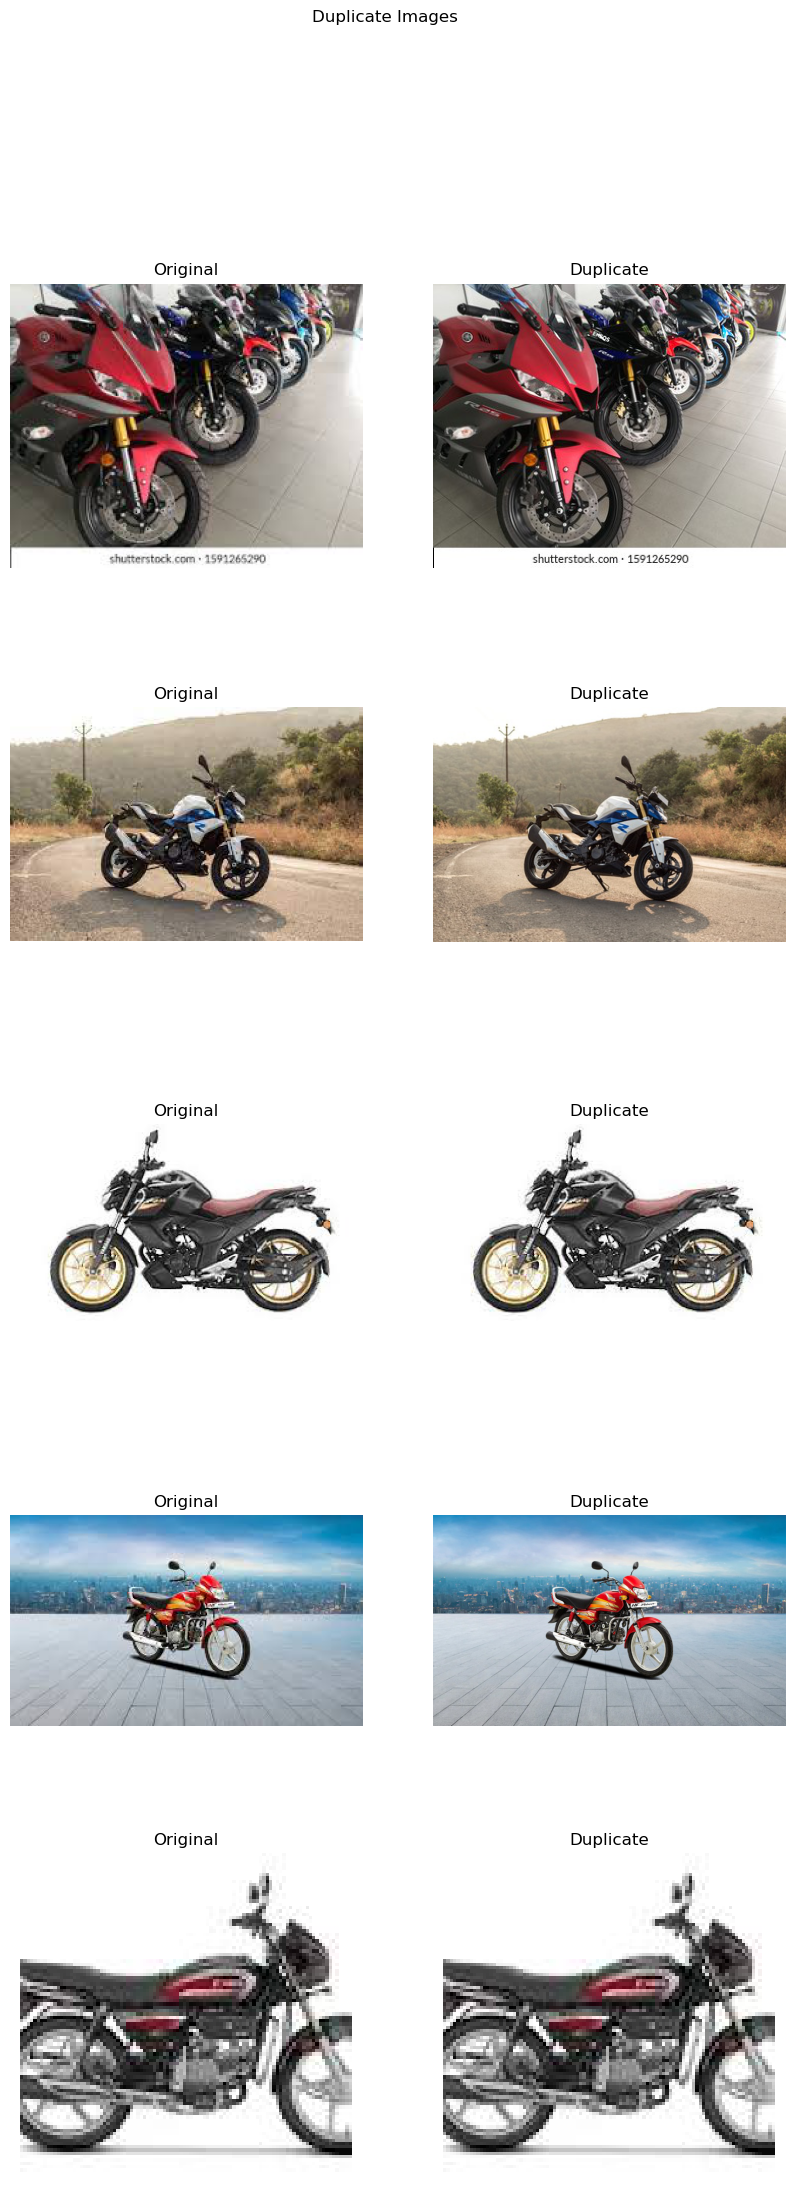

In [14]:

def display_duplicate_samples(duplicates, title, num=5):
    """Display sample duplicate images side by side with their originals."""
    if len(duplicates) == 0:
        print(f"No duplicate pairs to display for {title}.")
        return
    
    sample_pairs = random.sample(list(duplicates.items()), min(num, len(duplicates)))
    fig, axes = plt.subplots(len(sample_pairs), 2, figsize=(10, 5 * len(sample_pairs)))
    
    for ax_row, (original_key, duplicate_list) in zip(axes, sample_pairs):
        original = duplicate_list["original"]  # Get the original image
        ax_row[0].imshow(original.astype(np.uint8))
        ax_row[0].set_title("Original")
        ax_row[0].axis('off')
        
        ax_row[1].imshow(duplicate_list["duplicates"][0].astype(np.uint8))  # Show one of the duplicates
        ax_row[1].set_title("Duplicate")
        ax_row[1].axis('off')
    
    plt.suptitle(title)
    plt.show()

def remove_duplicate_images(images, labels):
    """Detect and remove visually similar images using dHash, ensuring labels remain in sync."""
    hashes = {}
    unique_images = []
    unique_labels = []
    duplicate_images = defaultdict(lambda: {"original": None, "duplicates": []})

    for img, label in zip(images, labels):
        pil_img = Image.fromarray(img.astype(np.uint8))  # Ensure correct dtype
        hash_val = str(imagehash.dhash(pil_img))  # Convert hash to string for dictionary key
        
        if hash_val not in hashes:
            hashes[hash_val] = img  # Store original image
            unique_images.append(img)
            unique_labels.append(label)  # Keep the label
        else:
            duplicate_images[hash_val]["original"] = hashes[hash_val]
            duplicate_images[hash_val]["duplicates"].append(img)
    
    print(f"Found {sum(len(v['duplicates']) for v in duplicate_images.values())} duplicate images.")
    
    # Only display images if there are duplicates
    if duplicate_images:
        display_duplicate_samples(duplicate_images, "Duplicate Images")

    return unique_images, unique_labels

# Assuming images and labels are defined
images, labels = remove_duplicate_images(images, labels)

### Identify Anomalous Images
We identified anomalous images by analyzing their aspect ratios and detecting outliers. Using an anomaly detection approach, we compared the aspect ratios of all images and flagged those that significantly deviated from the common pattern. These outlier images were removed to maintain consistency and quality in the dataset.

In [15]:
def remove_anomalous_images(images, labels):
    """Detect outliers using Isolation Forest and remove extreme aspect ratios while keeping labels in sync."""
    
    resized_images = []
    valid_labels = []

    for img, label in zip(images, labels):
        # Extract image from tuple if necessary
        if isinstance(img, tuple):
            img = img[0]  

        # Convert numpy array to PIL Image if necessary
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        
        try:
            # Convert to RGB and resize
            img = img.convert('RGB')
            img_resized = img.resize((224, 224))
            resized_images.append(np.array(img_resized))
            valid_labels.append(label)  # Keep label only if image is valid
        except Exception as e:
            print(f"Error processing image: {e}")

    # Compute aspect ratios
    aspect_ratios = np.array([img.shape[1] / img.shape[0] for img in resized_images]).reshape(-1, 1)

    # Detect outliers using Isolation Forest
    clf = IsolationForest(contamination=0.05, random_state=42)
    outliers = clf.fit_predict(aspect_ratios)

    # Separate anomalous and normal images along with labels
    anomalous_images = [img for img, label in zip(resized_images, outliers) if label == -1]
    filtered_images = [img for img, label in zip(resized_images, outliers) if label == 1]
    filtered_labels = [lbl for lbl, label in zip(valid_labels, outliers) if label == 1]

    print(f"Found {len(anomalous_images)} anomalous images.")

    # Display anomalous images
    if anomalous_images:
        display_random_images(anomalous_images, "Anomalous Images")

    return filtered_images, filtered_labels

# Example Usage
images, labels = remove_anomalous_images(images, labels)


Found 0 anomalous images.


## **Data Completion**

In [16]:
def check_images(images):
    blank_or_corrupt_count = 0  # Missing Pixels (Blank or Corrupt Regions)
    corrupt_areas_count = 0  # Missing Pixels (Corrupt Areas)
    
    for img_array in images:
        # Convert to grayscale for analysis
        img_gray = Image.fromarray(img_array).convert("L")
        img_array_gray = np.array(img_gray)
        
        # Check for fully white or black images (Blank or Corrupt Regions)
        if np.all(img_array_gray == 255) or np.all(img_array_gray == 0):
            blank_or_corrupt_count += 1
        
        # Check for NaN values (Corrupt Areas)
        if np.isnan(img_array_gray).any():
            corrupt_areas_count += 1
    
    print(f"Number of images with Missing Pixels (Blank or Corrupt Regions): {blank_or_corrupt_count}")
    print(f"Number of images with Missing Pixels (Corrupt Areas): {corrupt_areas_count}")

check_images(images)

Number of images with Missing Pixels (Blank or Corrupt Regions): 0
Number of images with Missing Pixels (Corrupt Areas): 0


## **Dimensionality Reduction**

### Image Resizing 

In [17]:
def resize_images(all_images, target_size):
    resized_images = []
    for img in all_images:
        # If img is a tuple, extract the image object (assuming the first element of the tuple is the image)
        if isinstance(img, tuple):
            img = img[0]  # Assuming the first element of the tuple is the image

        # If img is a numpy array, convert it to PIL Image
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        
        try:
            # Ensure the image is a PIL Image and convert to RGB
            img = img.convert('RGB')
            img_resized = img.resize(target_size)
            resized_images.append(np.array(img_resized))
            
            # Store the size of the resized image
        except IOError as e:
            print(f"Cannot process image: {e}")

    return resized_images


resized_images = resize_images(images, target_size=(224, 224))

## **Data Balancing**

In [18]:
print(f"Final dataset contains {len(images)} images.")

Final dataset contains 3785 images.


Number of bike images: 1856
Number of car images: 1929


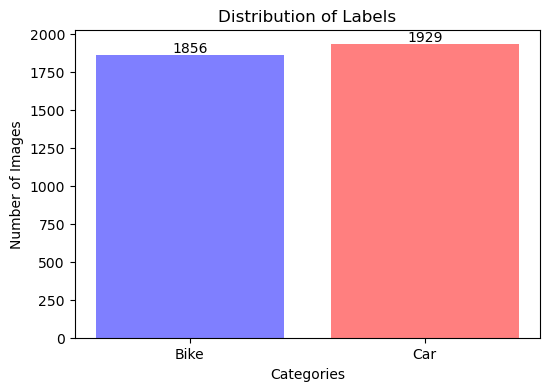

In [20]:
print(f"Number of bike images: {labels.count('Bike')}")
print(f"Number of car images: {labels.count('Car')}")

plt.figure(figsize=(6,4))
plt.bar(['Bike', 'Car'], [labels.count('Bike'), labels.count('Car')], color=['blue', 'red'], alpha=0.5)
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Distribution of Labels')

for i in range(2):
    plt.text(i, [labels.count('Bike'), labels.count('Car')][i], str([labels.count('Bike'), labels.count('Car')][i]), ha='center', va='bottom')

plt.show()


The dataset is **fairly balanced**. The difference between the two categories is 73 images, which is only about **1.9%** of the total dataset. The ratio is approximately 1:1.04, which is very close to balanced.

## **Normalization**
we apply image normalization techniques to ensure consistency in pixel intensity values across the dataset. Normalization helps improve model training by making the pixel distributions more uniform and reducing variations caused by lighting conditions and exposure differences. We perform:<br>
* **Pixel Intensity Normalization** – Scaling pixel values to the [0,1] range to standardize brightness levels.
* **Channel-Wise Normalization** – Standardizing pixel values using mean and standard deviation to ensure balanced feature distribution across color channels.

In [21]:
def normalize_images(images):
    """Apply Pixel Intensity Normalization and Channel-Wise Normalization."""
    
    images = np.array(images, dtype=np.float32)  # Ensure float type for proper scaling
    
    # Pixel Intensity Normalization: Scale pixels to [0,1] range
    images /= 255.0  
    
    # Compute mean and std per channel
    mean = np.mean(images, axis=(0, 1, 2), keepdims=True)  # Mean per channel
    std = np.std(images, axis=(0, 1, 2), keepdims=True)    # Standard deviation per channel
    
    # Avoid division by zero
    std[std == 0] = 1e-8  
    
    # Channel-Wise Normalization: Standardize pixel values
    images = (images - mean) / std  

    return images

# Apply normalization
normalized_images = normalize_images(resized_images)

# Print shape and check min/max values
print(f"Normalized Images Shape: {normalized_images.shape}")
print(f"Min Pixel Value: {normalized_images.min()}, Max Pixel Value: {normalized_images.max()}")

Normalized Images Shape: (3785, 224, 224, 3)
Min Pixel Value: -0.2972206771373749, Max Pixel Value: 3.0672831535339355


In [22]:
# Encode labels
label_dict = {'Bike': 0, 'Car': 1}
labels = np.array([label_dict[label] for label in labels])

images_ready_to_work=resized_images.copy()
labels_ready_to_work = labels.copy()

## Feature Engineering

Minimal feature engineering was done, as CNNs automatically extract spatial and texture features.
#### Essential preprocessing steps included:
- Removal of 211 duplicate images using dHash.
- Anomaly detection using Isolation Forest to ensure no outliers.
- Confirmation of no broken or corrupted images.
- Resizing all images to 224x224 pixels for consistency.
- Normalization of pixel values to [0, 1].
The dataset was well-balanced with only a 1.9% class imbalance, so no further adjustments were necessary.


# **Machine Learning Algorithms**

In [23]:
# Convert list of images to a NumPy array
X = np.array(normalized_images)  
X = X.reshape(X.shape[0], -1)  # Flatten images for ML model

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, labels_ready_to_work, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
print("="*40)
print("📊 Dataset Split Summary 📊")
print("="*40)
print(f"🔹 Training Set     : {len(X_train):,} images")
print(f"🔹 Validation Set   : {len(X_val):,} images")
print(f"🔹 Test Set        : {len(X_test):,} images")
print("="*40)

📊 Dataset Split Summary 📊
🔹 Training Set     : 2,649 images
🔹 Validation Set   : 568 images
🔹 Test Set        : 568 images


Logistic Regression Preformence:
Training Accuracy: 1.0000
Validation Accuracy: 0.7324
F1 Score: 0.7397
Precision: 0.7059
Recall: 0.7770
ROC-AUC Score: 0.8092
Log Loss: 2.4868
Matthews Correlation Coefficient (MCC): 0.4679
Cohen’s Kappa Score: 0.4657

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       290
           1       0.71      0.78      0.74       278

    accuracy                           0.73       568
   macro avg       0.73      0.73      0.73       568
weighted avg       0.74      0.73      0.73       568

Confusion Matrix:
[[200  90]
 [ 62 216]]


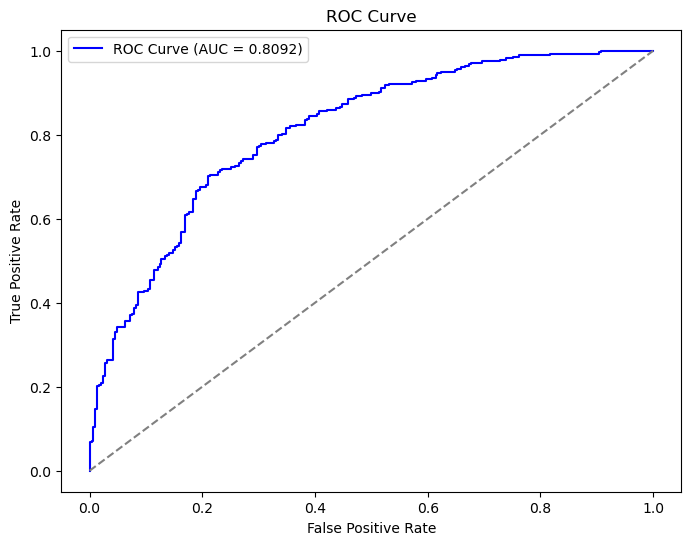

In [25]:
# Train Logistic Regression model
model = LogisticRegression(max_iter=500, solver='lbfgs', random_state=42)
model.fit(X_train, y_train)

# Predict on val data
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for ROC-AUC

# Predict on training data
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on validation data
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for ROC-AUC

# Compute validation performance metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
logloss = log_loss(y_val, y_pred_proba)
mcc = matthews_corrcoef(y_val, y_pred)
cohen_kappa = cohen_kappa_score(y_val, y_pred)

# Print Metrics
print("Logistic Regression Preformence:")
print(f"Training Accuracy: {train_accuracy:.4f}")  # New addition
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen’s Kappa Score: {cohen_kappa:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Random Forest Preformence:
Training Accuracy: 1.0000
Validation Accuracy: 0.7905
F1 Score: 0.7938
Precision: 0.7659
Recall: 0.8237
ROC-AUC Score: 0.8764
Log Loss: 0.4889
Matthews Correlation Coefficient (MCC): 0.5830
Cohen’s Kappa Score: 0.5815

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       290
           1       0.77      0.82      0.79       278

    accuracy                           0.79       568
   macro avg       0.79      0.79      0.79       568
weighted avg       0.79      0.79      0.79       568

Confusion Matrix:
[[220  70]
 [ 49 229]]


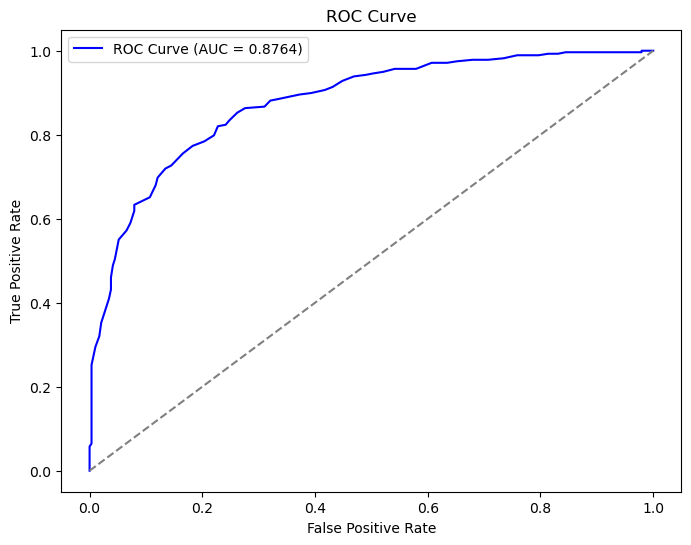

In [26]:
# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for ROC-AUC

# Predict on training data
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on validation data
y_val_pred = model.predict(X_val)
y_val_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for ROC-AUC

# Compute validation performance metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
logloss = log_loss(y_val, y_pred_proba)
mcc = matthews_corrcoef(y_val, y_pred)
cohen_kappa = cohen_kappa_score(y_val, y_pred)

# Print Metrics
print("Random Forest Preformence:")
print(f"Training Accuracy: {train_accuracy:.4f}")  # New addition
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print(f"Cohen’s Kappa Score: {cohen_kappa:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

We can see that Random forest is better, but deep learning should exceed it.

# **Neural Networks**

In [50]:
# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(normalized_images, labels_ready_to_work, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [67]:
# Define CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate = 0.5):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers (adjusted based on feature map size)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Check input size before flattening
        self.fc2 = nn.Linear(512, num_classes)
        
        # Activation & Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPool
        x = self.pool(self.relu(self.conv3(x)))  # Conv3 + ReLU + MaxPool
        
        x = x.reshape(x.shape[0], -1)  # Flatten using reshape
        x = self.dropout(self.relu(self.fc1(x)))  # Fully Connected + ReLU + Dropout
        x = self.fc2(x)  # Output layer
        return x


# Model setup
num_classes = 2  # Binary classification
model = CNN(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Evaluation - Accuracy, Precision, Recall, F1-score
model.eval()

# Evaluate on training data
train_labels = []
train_predictions = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)

# Evaluate on validation data
val_labels = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.permute(0, 3, 1, 2) 
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predicted.cpu().numpy())

# Compute performance metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
report = classification_report(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Print metrics
print("CNN Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")  # New addition
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Epoch [1/3], Loss: 0.6309
Epoch [2/3], Loss: 0.2943
Epoch [3/3], Loss: 0.1997
CNN Model Performance:
Training Accuracy: 0.9524
Validation Accuracy: 0.9173
F1 Score: 0.9197
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.91       290
           1       0.88      0.97      0.92       278

    accuracy                           0.92       568
   macro avg       0.92      0.92      0.92       568
weighted avg       0.92      0.92      0.92       568

Confusion Matrix:
[[252  38]
 [  9 269]]


## Comparison to ML

In [2]:
# Model names and metrics
models = ['Logistic Regression', 'Random Forest', 'CNN']
validation_accuracy = [0.7324, 0.7905, 0.9173]
f1score = [0.7397, 0.7938, 0.9197]

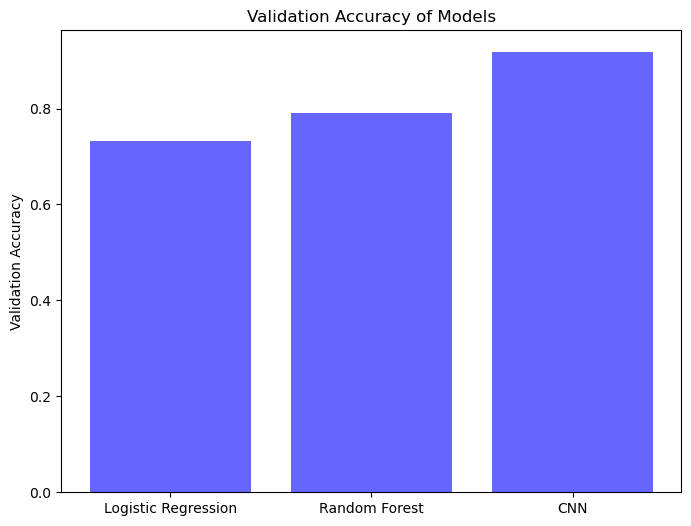

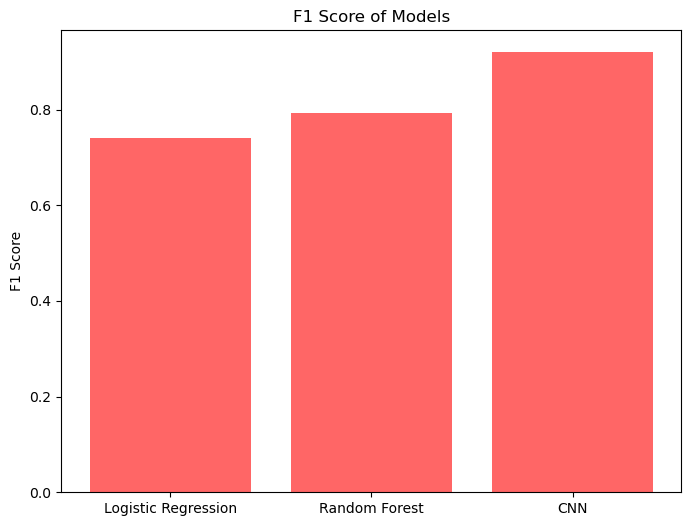

In [3]:
# Create figure and axis for validation accuracy
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(models, validation_accuracy, color='b', alpha=0.6)
ax.set_ylabel('Validation Accuracy')
ax.set_title('Validation Accuracy of Models')
plt.show()

# Create figure and axis for F1 Score
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(models, f1score, color='r', alpha=0.6)
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score of Models')
plt.show()


# **Hyperparameter Tuning**

In [69]:
# Define hyperparameter variations
default_lr = 0.001
default_dropout = 0.5
default_weight_decay = 0

lrs = [0.0001, 0.001, 0.01]
dropouts = [0.3, 0.5, 0.7]
weight_decays = [0, 0.0005, 0.0001]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Placeholder for results
results = []


# Train and evaluate models with 9 different settings
configs = [
    {'learning_rate': lr, 'dropout': default_dropout, 'weight_decay': default_weight_decay} for lr in lrs
] + [
    {'learning_rate': default_lr, 'dropout': dr, 'weight_decay': default_weight_decay} for dr in dropouts
] + [
    {'learning_rate': default_lr, 'dropout': default_dropout, 'weight_decay': wd} for wd in weight_decays
]

for config in configs:
    lr = config['learning_rate']
    dropout = config['dropout']
    wd = config['weight_decay']
    print(f"Training model with lr={lr}, dropout={dropout}, weight_decay={wd}")
    
    model = CNN(num_classes=2, dropout_rate=dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    
    # Train the model
    epochs = 5
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images.permute(0, 3, 1, 2))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # Evaluate the model
    model.eval()

    # Compute training accuracy
    y_train_true, y_train_pred = [], []
    with torch.no_grad():
        for images, labels in train_loader:
            images = images.to(device)
            outputs = model(images.permute(0, 3, 1, 2))
            _, preds = torch.max(outputs, 1)
            y_train_pred.extend(preds.cpu().numpy())
            y_train_true.extend(labels.cpu().numpy())

    train_accuracy = accuracy_score(y_train_true, y_train_pred)

    # Compute validation accuracy
    y_val_true, y_val_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images.permute(0, 3, 1, 2))
            _, preds = torch.max(outputs, 1)
            y_val_pred.extend(preds.cpu().numpy())
            y_val_true.extend(labels.cpu().numpy())

    # Compute performance metrics
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    f1 = f1_score(y_val_true, y_val_pred)
    precision = precision_score(y_val_true, y_val_pred)
    recall = recall_score(y_val_true, y_val_pred)
    conf_matrix = confusion_matrix(y_val_true, y_val_pred)

    # Save results
    results.append({
        'learning_rate': lr,
        'dropout': dropout,
        'weight_decay': wd,
        'train_accuracy': train_accuracy,  
        'val_accuracy': val_accuracy,
        'f1_score': f1,
        'recall': recall,
        'precision': precision,
        'conf_matrix': conf_matrix
    })

    print(f"Training Accuracy: {train_accuracy:.4f}")  
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

Training model with lr=0.0001, dropout=0.5, weight_decay=0
Epoch 1/5, Loss: 0.6413
Epoch 2/5, Loss: 0.3344
Epoch 3/5, Loss: 0.2237
Epoch 4/5, Loss: 0.1661
Epoch 5/5, Loss: 0.1276
Training Accuracy: 0.9724
Validation Accuracy: 0.9243
F1 Score: 0.9234
Precision: 0.9152
Recall: 0.9317
Confusion Matrix:
[[266  24]
 [ 19 259]]
Training model with lr=0.001, dropout=0.5, weight_decay=0
Epoch 1/5, Loss: 0.6210
Epoch 2/5, Loss: 0.2670
Epoch 3/5, Loss: 0.1674
Epoch 4/5, Loss: 0.1310
Epoch 5/5, Loss: 0.0863
Training Accuracy: 0.9872
Validation Accuracy: 0.9225
F1 Score: 0.9231
Precision: 0.8980
Recall: 0.9496
Confusion Matrix:
[[260  30]
 [ 14 264]]
Training model with lr=0.01, dropout=0.5, weight_decay=0
Epoch 1/5, Loss: 16.4366
Epoch 2/5, Loss: 0.6927
Epoch 3/5, Loss: 0.6930
Epoch 4/5, Loss: 0.6925
Epoch 5/5, Loss: 0.6931
Training Accuracy: 0.5172
Validation Accuracy: 0.4894
F1 Score: 0.6572
Precision: 0.4894
Recall: 1.0000
Confusion Matrix:
[[  0 290]
 [  0 278]]
Training model with lr=0.001, 

In [70]:
# Convert results to DataFrame
results_df_cnn = pd.DataFrame(results)
results_df_cnn

learning_rate  dropout  weight_decay  train_accuracy  val_accuracy  \
0         0.0001      0.5        0.0000        0.972442      0.924296   
1         0.0010      0.5        0.0000        0.987165      0.922535   
2         0.0100      0.5        0.0000        0.517176      0.489437   
3         0.0010      0.3        0.0000        0.967912      0.910211   
4         0.0010      0.5        0.0000        0.997357      0.906690   
5         0.0010      0.7        0.0000        0.987920      0.934859   
6         0.0010      0.5        0.0000        0.990562      0.929577   
7         0.0010      0.5        0.0005        0.978860      0.910211   
8         0.0010      0.5        0.0001        0.986410      0.931338   

   f1_score    recall  precision             conf_matrix  
0  0.923351  0.931655   0.915194  [[266, 24], [19, 259]]  
1  0.923077  0.949640   0.897959  [[260, 30], [14, 264]]  
2  0.657210  1.000000   0.489437    [[0, 290], [0, 278]]  
3  0.905380  0.877698   0.934866  [[273, 17], [34, 244]]  
4  0.908463  0.946043   0.873754  [[252, 38], [15, 263]]  
5  0.935428  0.964029   0.908475  [[263, 27], [10, 268]]  
6  0.928826  0.938849   0.919014  [[267, 23], [17, 261]]  
7  0.911917  0.949640   0.877076  [[253, 37], [14, 264]]  
8  0.931217  0.949640   0.913495  [[265, 25], [14, 264]]

The "best" hyperparameters are learning_rate=0.0001, dropout=0.7, weight_decay=0.0001 . 
We didn't look on all of the possible combinations due to long running times.

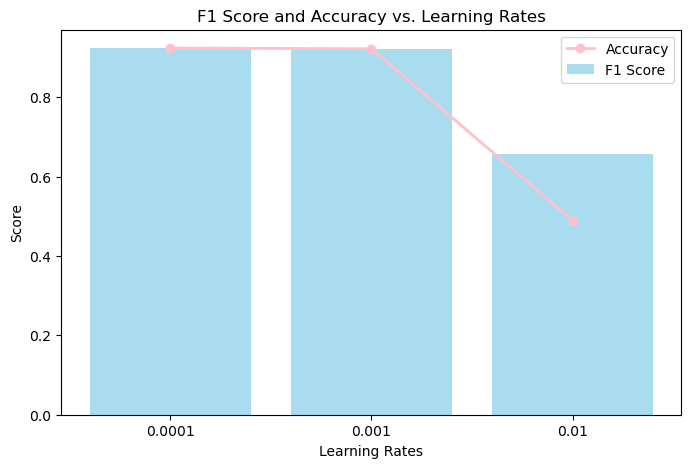

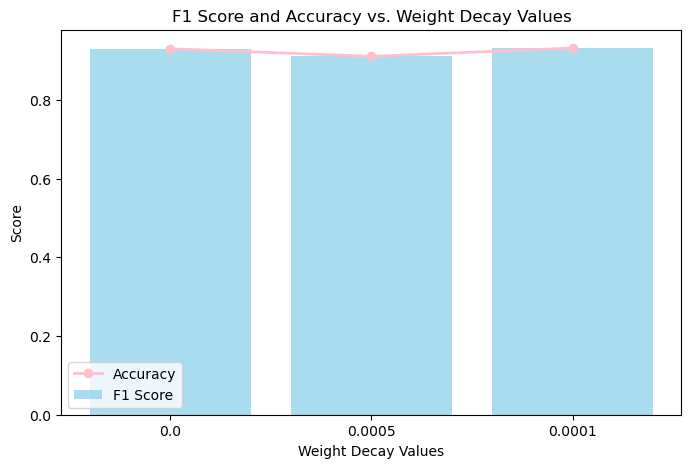

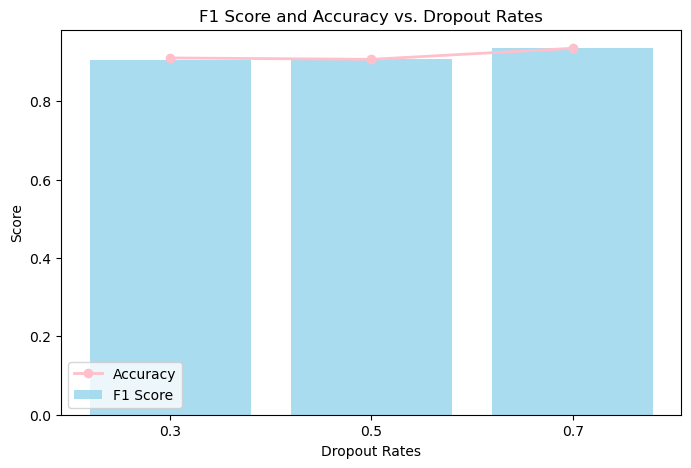

In [71]:
# Extract data from results_df_cnn
learning_rates = results_df_cnn.iloc[:3, :]['learning_rate'].astype(str)
f1_scores = results_df_cnn.iloc[:3, :]['f1_score']
accuracy = results_df_cnn.iloc[:3, :]['val_accuracy']

# Create plot
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(learning_rates, f1_scores, color='skyblue', alpha=0.7, label='F1 Score')
ax.plot(learning_rates, accuracy, marker='o', color='pink', linestyle='-', linewidth=2, label='Accuracy')

# Labels and title
ax.set_xlabel("Learning Rates")
ax.set_ylabel("Score")
ax.set_title("F1 Score and Accuracy vs. Learning Rates")
ax.legend()

plt.show()


# Extract data from results_df_cnn
weight_decay = results_df_cnn.iloc[6:, :]['weight_decay'].astype(str)
f1_scores = results_df_cnn.iloc[6:, :]['f1_score']
accuracy = results_df_cnn.iloc[6:, :]['val_accuracy']

# Create plot
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(weight_decay, f1_scores, color='skyblue', alpha=0.7, label='F1 Score')
ax.plot(weight_decay, accuracy, marker='o', color='pink', linestyle='-', linewidth=2, label='Accuracy')

# Labels and title
ax.set_xlabel("Weight Decay Values")
ax.set_ylabel("Score")
ax.set_title("F1 Score and Accuracy vs. Weight Decay Values")
ax.legend()

plt.show()

# Extract data from results_df_cnn
dropout_rates = results_df_cnn.iloc[3:6, :]['dropout'].astype(str)
f1_scores = results_df_cnn.iloc[3:6, :]['f1_score']
accuracy = results_df_cnn.iloc[3:6, :]['val_accuracy']

# Create plot
fig, ax = plt.subplots(figsize=(8,5))
ax.bar(dropout_rates, f1_scores, color='skyblue', alpha=0.7, label='F1 Score')
ax.plot(dropout_rates, accuracy, marker='o', color='pink', linestyle='-', linewidth=2, label='Accuracy')

# Labels and title
ax.set_xlabel("Dropout Rates")
ax.set_ylabel("Score")
ax.set_title("F1 Score and Accuracy vs. Dropout Rates")
ax.legend()

plt.show()

# **Dataset Expansion through Augmentation**

We will try to improve the model by adding augmentations to the train dataset. This way the model should learn more diverse features, enhancing its ability to generalize better to unseen data. We will add 1000 augmentations.

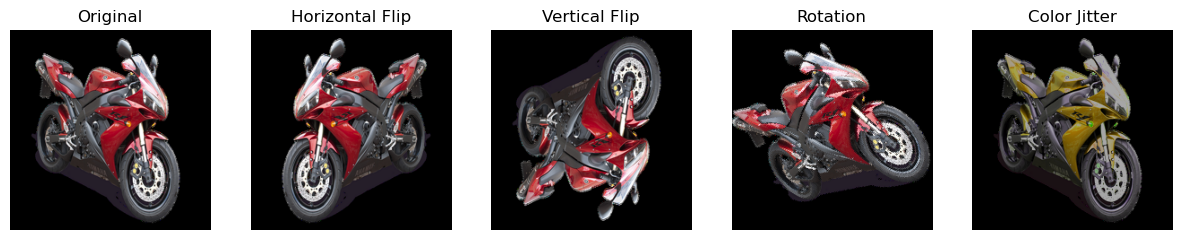

Total number of images: 3649
Number of Bikes: 1988
Number of Cars: 1661


In [53]:
augmentations = transforms.Compose([
    RandomApply([transforms.RandomHorizontalFlip()], p=0.7),
    RandomApply([transforms.RandomVerticalFlip()], p=0.7),
    RandomApply([transforms.RandomRotation(degrees=30)], p=0.5),
    RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.5),
])

def numpy_to_pil_image(numpy_array):
    """Convert a NumPy array or Tensor to a PIL image."""
    if isinstance(numpy_array, torch.Tensor):  # Convert tensor to NumPy
        numpy_array = numpy_array.cpu().numpy()  # Ensure it's on CPU before conversion
    return Image.fromarray(numpy_array.astype(np.uint8))  # Ensure dtype is uint8

def augment_images(images, labels, augmentation, num_images):
    """Augments images and returns augmented images with corresponding labels."""
    augmented_images = []
    augmented_labels = []
    
    for _ in range(num_images):
        # Randomly select an image and its corresponding label
        idx = np.random.randint(0, len(images))
        original_image = images_ready_to_work[idx]
        original_label = labels_ready_to_work[idx]  # Retrieve corresponding label
        
        # Convert Tensor to NumPy if needed
        original_image_pil = numpy_to_pil_image(original_image)
        
        # Apply augmentation
        augmented_image_pil = augmentation(original_image_pil)
        
        # Convert augmented PIL image back to NumPy array
        augmented_image_np = np.array(augmented_image_pil)
        
        # Store augmented image and corresponding label
        augmented_images.append(augmented_image_np)
        augmented_labels.append(original_label)

    return augmented_images, augmented_labels

# Ensure images are in NumPy format before calling augment_images
augmented_images, augmented_labels = augment_images(X_train, y_train, augmentations, num_images=1000)

def plot_augmentations(original_image, augmentations):
    """Plot original image with different augmentations."""
    
    # If the dataset returns a tuple (image, label), extract the image
    if isinstance(original_image, tuple):
        original_image, _ = original_image  # Extract image only

    # Convert PyTorch tensor to NumPy if necessary
    if isinstance(original_image, torch.Tensor):
        if original_image.dim() == 4:  # If batch (N, C, H, W), select first image
            original_image = original_image[0]
        if original_image.shape[0] in [1, 3]:  # If (C, H, W) format
            original_image = original_image.permute(1, 2, 0)  # Convert (C, H, W) → (H, W, C)
        original_image = original_image.cpu().numpy()

    # Ensure image is in uint8 format (0-255)
    if original_image.dtype in [np.float32, np.float64] and original_image.max() <= 1:
        original_image = (original_image * 255).astype(np.uint8)

    # Ensure grayscale or RGB image shape
    if len(original_image.shape) == 2:  # Grayscale image
        original_image_pil = Image.fromarray(original_image, mode="L")
    elif original_image.shape[-1] == 3:  # RGB image
        original_image_pil = Image.fromarray(original_image)
    else:
        raise ValueError(f"Unexpected image shape: {original_image.shape}. Expected (H, W, 3) for RGB.")

    # Create subplots
    fig, axes = plt.subplots(1, len(augmentations) + 1, figsize=(15, 5))

    # Plot the original image
    axes[0].imshow(original_image_pil, cmap="gray" if original_image_pil.mode == "L" else None)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Apply each augmentation and plot
    augmentation_names = ['Horizontal Flip', 'Vertical Flip', 'Rotation', 'Color Jitter']
    for i, (augmentation, name) in enumerate(zip(augmentations, augmentation_names), start=1):
        augmented_image_pil = augmentation(original_image_pil)
        axes[i].imshow(augmented_image_pil, cmap="gray" if original_image_pil.mode == "L" else None)
        axes[i].set_title(f'{name}')
        axes[i].axis('off')

    plt.show()


augmentations_to_plot = [
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
]

# Plot augmentations
plot_augmentations(resized_images[2], augmentations_to_plot)

normalized_augmented_images = normalize_images(augmented_images)


all_images_train = np.concatenate([normalized_augmented_images, X_train], axis=0)
all_labels_train = np.concatenate([augmented_labels, y_train], axis=0)

print("Total number of training images:", all_images_train.shape[0])

print("Number of Bikes:", np.sum(all_labels_train == 0))
print("Number of Cars:", np.sum(all_labels_train == 1))


In [58]:
# Convert to PyTorch tensors
all_images_train, all_labels_train = torch.tensor(all_images_train, dtype=torch.float32), torch.tensor(all_labels_train, dtype=torch.long)

# Create data loaders
train_augmented_dataset = TensorDataset(all_images_train, all_labels_train)

train_augmented_loader = DataLoader(train_augmented_dataset, batch_size=32, shuffle=True)


# Model setup
num_classes = 2  # Binary classification
model_aug = CNN(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters())

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model_aug.train()
    total_loss = 0
    
    for images, labels in train_augmented_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model_aug(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_augmented_loader):.4f}")

# Evaluation - Accuracy, Precision, Recall, F1-score
model_aug.eval()

# Compute training accuracy
train_labels = []
train_predictions = []

with torch.no_grad():
    for images, labels in train_augmented_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model_aug(images)
        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)

# Compute validation accuracy
val_labels = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.permute(0, 3, 1, 2) 
        outputs = model_aug(images)
        _, predicted = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predicted.cpu().numpy())



C:\Users\adamb\AppData\Local\Temp\ipykernel_4180\4198414028.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_images_train, all_labels_train = torch.tensor(all_images_train, dtype=torch.float32), torch.tensor(all_labels_train, dtype=torch.long)


Epoch [1/3], Loss: 0.7104
Epoch [2/3], Loss: 0.2710
Epoch [3/3], Loss: 0.1912


In [57]:
# Compute performance metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
report = classification_report(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Print metrics
print("CNN Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")  
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

CNN Model Performance:
Training Accuracy: 0.9501
Validation Accuracy: 0.9542
F1 Score: 0.9520
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       290
           1       0.98      0.93      0.95       278

    accuracy                           0.95       568
   macro avg       0.96      0.95      0.95       568
weighted avg       0.96      0.95      0.95       568

Confusion Matrix:
[[284   6]
 [ 20 258]]


By adding 1000 augmented images to the training data, we observed a significant increase in validation accuracy, rising from 92% to 95.5%.

# **Dataset Reduction via Undersampling**

In [61]:
# Randomly select 100 instances from the original X_train
random_indices = np.random.choice(len(X_train), size=100, replace=False)
X_train_selected = X_train[random_indices]
y_train_selected = y_train[random_indices]

# Convert to PyTorch tensors
subset_train, subset_labels_train = torch.tensor(X_train_selected, dtype=torch.float32), torch.tensor(y_train_selected, dtype=torch.long)

# Create data loaders
train_subset_dataset = TensorDataset(subset_train, subset_labels_train)
train_subset_loader = DataLoader(train_subset_dataset, batch_size=32, shuffle=True)

# Model setup
num_classes = 2  # Binary classification
model_sub = CNN(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_sub.parameters())

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model_sub.train()
    total_loss = 0
    
    for images, labels in train_subset_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model_sub(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_subset_loader):.4f}")

# Evaluation - Accuracy, Precision, Recall, F1-score
model_sub.eval()

# Compute training accuracy
train_labels = []
train_predictions = []

with torch.no_grad():
    for images, labels in train_subset_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model_sub(images)
        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)

# Compute validation accuracy
val_labels = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model_sub(images)
        _, predicted = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predicted.cpu().numpy())



C:\Users\adamb\AppData\Local\Temp\ipykernel_4180\3035831713.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  subset_train, subset_labels_train = torch.tensor(X_train_selected, dtype=torch.float32), torch.tensor(y_train_selected, dtype=torch.long)


Epoch [1/3], Loss: 6.6817
Epoch [2/3], Loss: 1.1802
Epoch [3/3], Loss: 0.6321


In [62]:
# Compute performance metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
report = classification_report(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Print metrics
print("CNN Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")  # New addition
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)


CNN Model Performance:
Training Accuracy: 0.5400
Validation Accuracy: 0.4894
F1 Score: 0.6572
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       290
           1       0.49      1.00      0.66       278

    accuracy                           0.49       568
   macro avg       0.24      0.50      0.33       568
weighted avg       0.24      0.49      0.32       568

Confusion Matrix:
[[  0 290]
 [  0 278]]


C:\Users\adamb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adamb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adamb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


With only 100 images to train on, the model underfits and predicts only one class.

## Better Architecture

Added another convolution and fully connected layers:

In [152]:
class CNN2(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CNN2, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        # The size of the flattened layer will depend on the input image size
        self.fc1 = nn.Linear(256 * 14 * 14, 1024)  # Adjusted for output size
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        
        # Activation & Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 + ReLU + MaxPool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 + ReLU + MaxPool
        x = self.pool(self.relu(self.conv3(x)))  # Conv3 + ReLU + MaxPool
        x = self.pool(self.relu(self.conv4(x)))  # Conv4 + ReLU + MaxPool
        
        # Flatten the tensor dynamically
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension
        x = self.dropout(self.relu(self.fc1(x)))  # Fully Connected + ReLU + Dropout
        x = self.dropout(self.relu(self.fc2(x)))  # Fully Connected + ReLU + Dropout
        x = self.fc3(x)  # Output layer
        return x

In [77]:
# Model setup
num_classes = 2  # Binary classification
model = CNN2(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Initialize lists to track accuracy and time
train_accuracies = []
val_accuracies = []
epoch_times = []

# Training loop with time tracking
num_epochs = 3
start_total_time = time.time()  # Start total timer

for epoch in range(num_epochs):
    start_time = time.time()  # Start epoch timer
    model.train()
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    end_time = time.time()  # End epoch timer
    epoch_time = end_time - start_time  # Calculate time taken for epoch
    epoch_times.append(epoch_time)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Time: {epoch_time:.2f} seconds")

# Total training time
end_total_time = time.time()
total_training_time = end_total_time - start_total_time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# Evaluation - Accuracy, Precision, Recall, F1-score
model.eval()

# Evaluate on training data
train_labels = []
train_predictions = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)

# Evaluate on validation data
val_labels = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predicted.cpu().numpy())

# Compute performance metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
report = classification_report(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Print metrics
print("CNN Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")  
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)


Epoch [1/3], Loss: 0.6707, Time: 92.90 seconds
Epoch [2/3], Loss: 0.3987, Time: 89.54 seconds
Epoch [3/3], Loss: 0.2261, Time: 88.47 seconds
Total Training Time: 270.91 seconds
CNN Model Performance:
Training Accuracy: 0.9324
Validation Accuracy: 0.9384
F1 Score: 0.9369
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       290
           1       0.94      0.94      0.94       278

    accuracy                           0.94       568
   macro avg       0.94      0.94      0.94       568
weighted avg       0.94      0.94      0.94       568

Confusion Matrix:
[[273  17]
 [ 18 260]]


The previous model, with time stamps:

In [78]:
# Model setup
num_classes = 2  # Binary classification
model = CNN(num_classes) # previous CNN

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Initialize lists to track accuracy and time
train_accuracies = []
val_accuracies = []
epoch_times = []

# Training loop with time tracking
num_epochs = 3
start_total_time = time.time()  # Start total timer

for epoch in range(num_epochs):
    start_time = time.time()  # Start epoch timer
    model.train()
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    end_time = time.time()  # End epoch timer
    epoch_time = end_time - start_time  # Calculate time taken for epoch
    epoch_times.append(epoch_time)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Time: {epoch_time:.2f} seconds")

# Total training time
end_total_time = time.time()
total_training_time = end_total_time - start_total_time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# Evaluation - Accuracy, Precision, Recall, F1-score
model.eval()

# Evaluate on training data
train_labels = []
train_predictions = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)

# Evaluate on validation data
val_labels = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predicted.cpu().numpy())

# Compute performance metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
report = classification_report(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Print metrics
print("CNN Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")  
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)


Epoch [1/3], Loss: 0.7056, Time: 79.53 seconds
Epoch [2/3], Loss: 0.2805, Time: 80.47 seconds
Epoch [3/3], Loss: 0.1962, Time: 79.85 seconds
Total Training Time: 239.86 seconds
CNN Model Performance:
Training Accuracy: 0.9619
Validation Accuracy: 0.9225
F1 Score: 0.9209
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       290
           1       0.92      0.92      0.92       278

    accuracy                           0.92       568
   macro avg       0.92      0.92      0.92       568
weighted avg       0.92      0.92      0.92       568

Confusion Matrix:
[[268  22]
 [ 22 256]]


The added layers improved the model validation accuracy by more than 1.5%, while adding a total of 30 seconds to the training.

## Adding new metric for training evaluation

The original model-

In [80]:
# Model setup
num_classes = 2  # Binary classification
model = CNN(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Initialize lists to track accuracy, AUC, and probabilities for each epoch
train_accuracies = []
val_accuracies = []
train_probs_per_epoch = []  # List to store train probabilities for each epoch
train_labels_per_epoch = []  # List to store train labels for each epoch
val_probs = []
val_labels = []

# Training loop with AUC calculation for each epoch
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    epoch_labels = []
    epoch_preds = []
    
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        # Collect labels and predictions for AUC
        epoch_labels.extend(labels.cpu().numpy())
        # Detach tensor to prevent it from requiring gradients
        epoch_preds.extend(torch.softmax(outputs, dim=1)[:, 1].detach().cpu().numpy())  # Get probability for class 1

    # Store train probabilities and labels for each epoch
    train_probs_per_epoch.append(epoch_preds)
    train_labels_per_epoch.append(epoch_labels)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/3], Loss: 0.7648
Epoch [2/3], Loss: 0.2355
Epoch [3/3], Loss: 0.1447


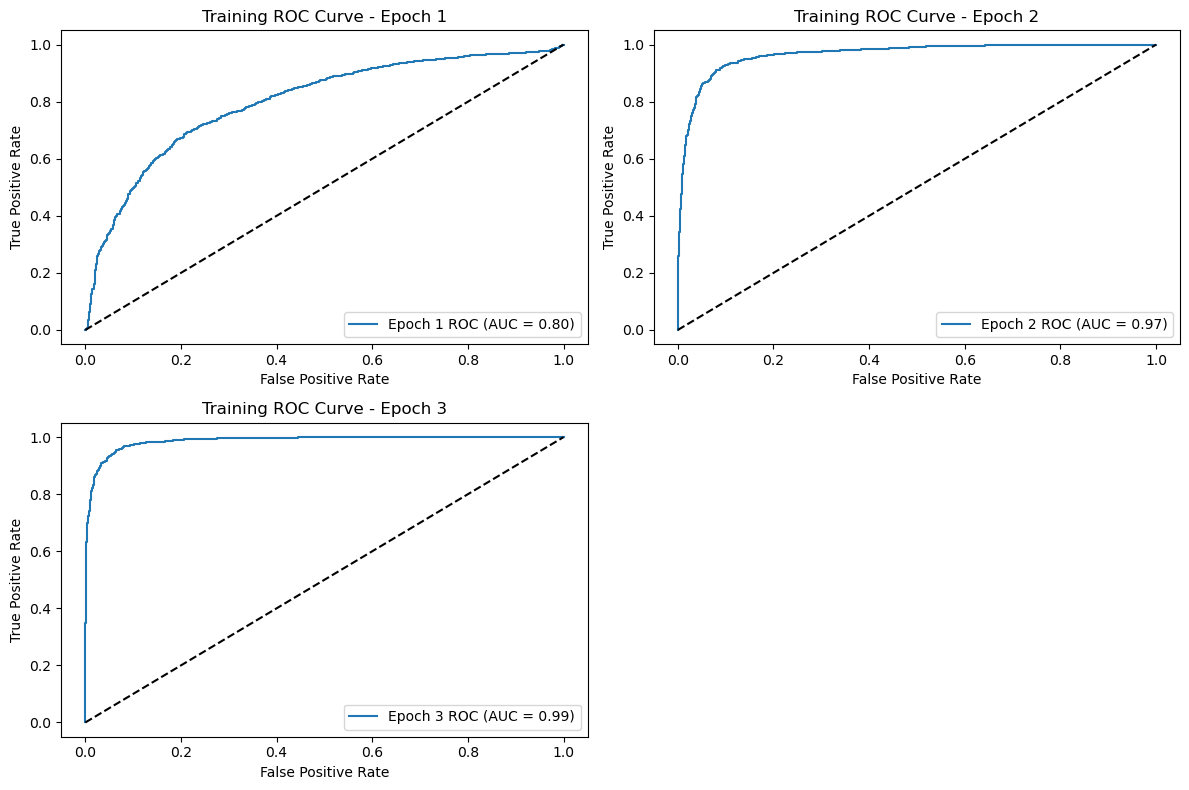

Final Performance Metrics:
Training Accuracy: 0.9619


In [86]:
# Compute AUC for each epoch
fpr_train, tpr_train, _ = roc_curve(train_labels_per_epoch[0], train_probs_per_epoch[0])
fpr_train_epoch2, tpr_train_epoch2, _ = roc_curve(train_labels_per_epoch[1], train_probs_per_epoch[1])
fpr_train_epoch3, tpr_train_epoch3, _ = roc_curve(train_labels_per_epoch[2], train_probs_per_epoch[2])

# Plot all ROC curves
plt.figure(figsize=(12, 8))

# Plot ROC for epoch 1
plt.subplot(2, 2, 1)
plt.plot(fpr_train, tpr_train, label=f'Epoch 1 ROC (AUC = {roc_auc_score(train_labels_per_epoch[0], train_probs_per_epoch[0]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Training ROC Curve - Epoch 1')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot ROC for epoch 2
plt.subplot(2, 2, 2)
plt.plot(fpr_train_epoch2, tpr_train_epoch2, label=f'Epoch 2 ROC (AUC = {roc_auc_score(train_labels_per_epoch[1], train_probs_per_epoch[1]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Training ROC Curve - Epoch 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

# Plot ROC for epoch 3
plt.subplot(2, 2, 3)
plt.plot(fpr_train_epoch3, tpr_train_epoch3, label=f'Epoch 3 ROC (AUC = {roc_auc_score(train_labels_per_epoch[2], train_probs_per_epoch[2]):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Training ROC Curve - Epoch 3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Print final performance metrics
print("Final Performance Metrics:")
print(f"Training Accuracy: {train_accuracy:.4f}")


We can see how the AUC highly increaces between the first and second epochs, while slightly inceacing in the third epoch as the model starts to converge.

## Changing the bias

In [108]:
# 1. Original Balanced Dataset 
X_train_balanced, y_train_balanced = X_train, y_train  # This remains as is, no changes

# 2. Small downsample of class 0
class_0_size = int(len(X_train) * 0.25)
class_1_size = len(X_train) - class_0_size  # Remaining data will be class 1

class_0_size = int(len(X_train) * 0.25)
class_1_size = len(X_train) - class_0_size  # Remaining will be class 1

# Downsample class 0
X_train_class0_25, y_train_class0_25 = resample(X_train[y_train == 0],
                                                 y_train[y_train == 0],
                                                 replace=False,
                                                 n_samples=class_0_size,
                                                 random_state=42)

# Keep all of class 1
X_train_class1_25 = X_train[y_train == 1]
y_train_class1_25 = y_train[y_train == 1]

# Combine the two classes back together
X_train_25 = np.concatenate([X_train_class0_25, X_train_class1_25], axis=0)
y_train_25 = np.concatenate([y_train_class0_25, y_train_class1_25], axis=0)

# Big downsample of class 0
class_0_size = int(len(X_train) * 0.01)
class_1_size = len(X_train) - class_0_size  # Remaining data will be class 1

# Downsample class 0
X_train_class0_1, y_train_class0_1 = resample(X_train[y_train == 0],
                                               y_train[y_train == 0],
                                               replace=False,
                                               n_samples=class_0_size,
                                               random_state=42)

# Keep all of class 1
X_train_class1_1 = X_train[y_train == 1]
y_train_class1_1 = y_train[y_train == 1]

# Combine them back
X_train_1 = np.concatenate([X_train_class0_1, X_train_class1_1], axis=0)
y_train_1 = np.concatenate([y_train_class0_1, y_train_class1_1], axis=0)

# Create DataLoaders for each case
train_loader_original = DataLoader(TensorDataset(torch.tensor(X_train_balanced, dtype=torch.float32), 
                                                 torch.tensor(y_train_balanced, dtype=torch.long)), 
                                   batch_size=32, shuffle=True)

train_loader_small = DataLoader(TensorDataset(torch.tensor(X_train_25, dtype=torch.float32), 
                                            torch.tensor(y_train_25, dtype=torch.long)),
                             batch_size=32, shuffle=True)

train_loader_big = DataLoader(TensorDataset(torch.tensor(X_train_1, dtype=torch.float32), 
                                           torch.tensor(y_train_1, dtype=torch.long)),
                            batch_size=32, shuffle=True)


C:\Users\adamb\AppData\Local\Temp\ipykernel_4180\1323308956.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loader_original = DataLoader(TensorDataset(torch.tensor(X_train_balanced, dtype=torch.float32),
C:\Users\adamb\AppData\Local\Temp\ipykernel_4180\1323308956.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(y_train_balanced, dtype=torch.long)),


In [110]:
sum(y_train_25)/len(y_train_25)

0.6742125984251969

In [109]:
sum(y_train_1)/len(y_train_1)

0.9813753581661891

The biases are now 67% and 98%.

#### Small Bias

In [111]:
# Model setup
num_classes = 2  # Binary classification
model = CNN(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, labels in train_loader_small:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader_small):.4f}")

# Evaluation - Accuracy, Precision, Recall, F1-score
model.eval()

# Evaluate on training data
train_labels = []
train_predictions = []

with torch.no_grad():
    for images, labels in train_loader_small:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)

# Evaluate on validation data
val_labels = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.permute(0, 3, 1, 2) 
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predicted.cpu().numpy())

# Compute performance metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
report = classification_report(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Print metrics
print("CNN Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")  
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Epoch [1/3], Loss: 0.8589
Epoch [2/3], Loss: 0.3050
Epoch [3/3], Loss: 0.1782
CNN Model Performance:
Training Accuracy: 0.9690
Validation Accuracy: 0.9190
F1 Score: 0.9196
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       290
           1       0.89      0.95      0.92       278

    accuracy                           0.92       568
   macro avg       0.92      0.92      0.92       568
weighted avg       0.92      0.92      0.92       568

Confusion Matrix:
[[259  31]
 [ 15 263]]


#### High Bias

In [113]:
# Model setup
num_classes = 2  # Binary classification
model = CNN(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for images, labels in train_loader_big:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader_big):.4f}")

# Evaluation - Accuracy, Precision, Recall, F1-score
model.eval()

# Evaluate on training data
train_labels = []
train_predictions = []

with torch.no_grad():
    for images, labels in train_loader_big:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)

# Evaluate on validation data
val_labels = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.permute(0, 3, 1, 2) 
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predicted.cpu().numpy())

# Compute performance metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
report = classification_report(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Print metrics
print("CNN Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}")  
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

Epoch [1/3], Loss: 0.4612
Epoch [2/3], Loss: 0.1172
Epoch [3/3], Loss: 0.0935
CNN Model Performance:
Training Accuracy: 0.9814
Validation Accuracy: 0.4894
F1 Score: 0.6572
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       290
           1       0.49      1.00      0.66       278

    accuracy                           0.49       568
   macro avg       0.24      0.50      0.33       568
weighted avg       0.24      0.49      0.32       568

Confusion Matrix:
[[  0 290]
 [  0 278]]


C:\Users\adamb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adamb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\adamb\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


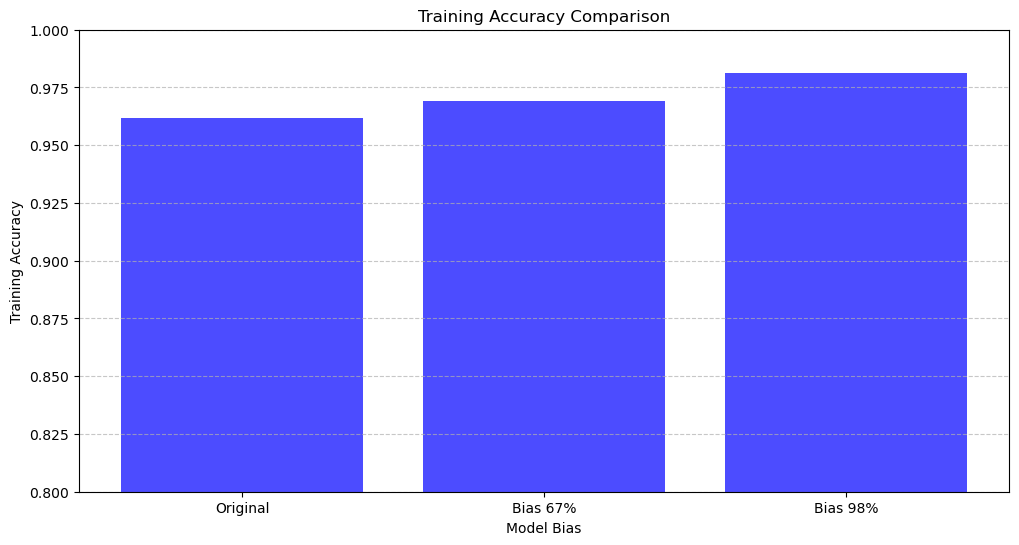

In [119]:
# Data from the performance comparison
epochs = ['Original', 'Bias 67%', 'Bias 98%']
train_accuracies = [0.9619, 0.9690, 0.9814]
val_accuracies = [0.9225, 0.9190, 0.4894]
val_f1_scores = [0.9209, 0.9196, 0.6572]

# Bar plot for training accuracy
plt.figure(figsize=(12, 6))
plt.bar(epochs, train_accuracies, color='b', alpha=0.7)
plt.xlabel('Model Bias')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.ylim([0.8, 1])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


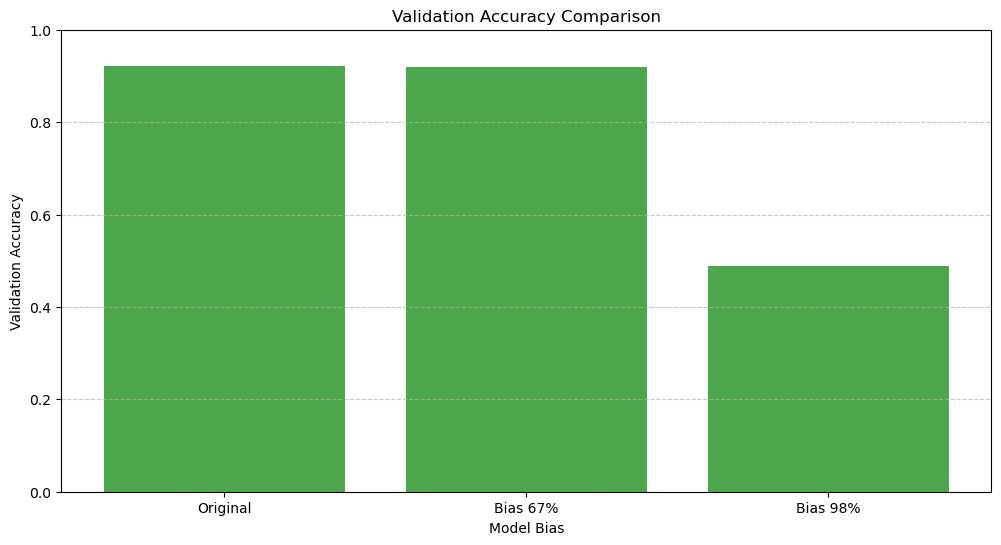

In [116]:
# Bar plot for validation accuracy
plt.figure(figsize=(12, 6))
plt.bar(epochs, val_accuracies, color='g', alpha=0.7)
plt.xlabel('Model Bias')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.ylim([0, 1])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()


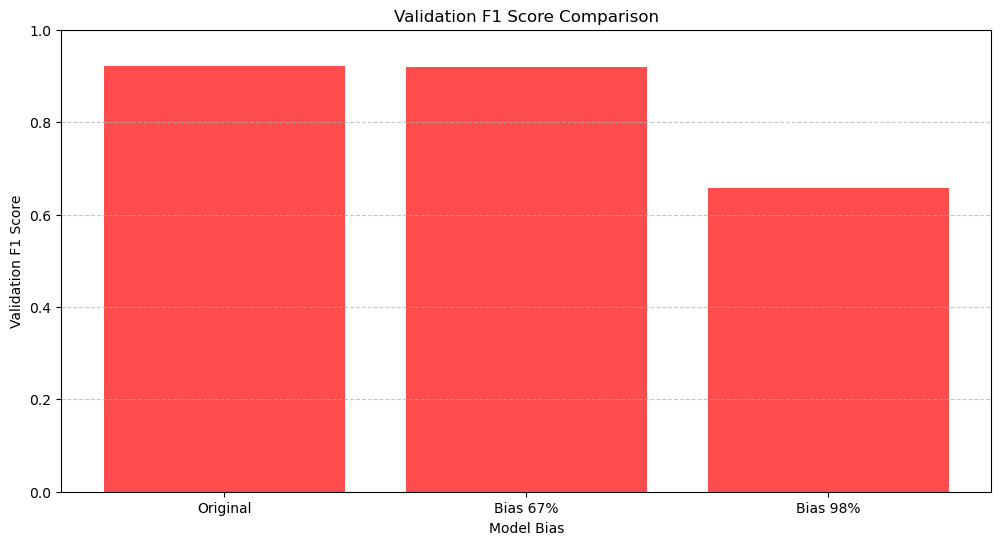

In [117]:
# Bar plot for validation F1 score
plt.figure(figsize=(12, 6))
plt.bar(epochs, val_f1_scores, color='r', alpha=0.7)
plt.xlabel('Model Bias')
plt.ylabel('Validation F1 Score')
plt.title('Validation F1 Score Comparison')
plt.ylim([0, 1])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

We can see that changing the bias by a bit don't change the results by much, while changing the bias strongly makes a dumb model which only predicts the upper class, achieving high training accuracy but poor results on the validation.

## Dimension reduction

Let's use 2 methods, one is PCA after flattening the picture, and the other is Pooling:

#### PCA

In [130]:

# Flatten the images before applying PCA
X_train_flattened = X_train.view(X_train.size(0), -1).numpy()  # Flatten the training images
X_val_flattened = X_val.view(X_val.size(0), -1).numpy()  # Flatten the validation images
X_test_flattened = X_test.view(X_test.size(0), -1).numpy()  # Flatten the test images

# Apply PCA - let's reduce the dimensions to 100 components 
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_flattened)
X_val_pca = pca.transform(X_val_flattened)
X_test_pca = pca.transform(X_test_flattened)


In [131]:
# Ensure both y_train and y_train_pred are numpy arrays
y_train = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else y_train
y_train_pred = y_train_pred.cpu().numpy() if isinstance(y_train_pred, torch.Tensor) else y_train_pred

# Ensure both y_val and y_val_pred are numpy arrays
y_val = y_val.cpu().numpy() if isinstance(y_val, torch.Tensor) else y_val
y_val_pred = y_val_pred.cpu().numpy() if isinstance(y_val_pred, torch.Tensor) else y_val_pred


In [132]:
# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Evaluate the model
y_pred = model.predict(X_val_pca)
y_pred_proba = model.predict_proba(X_val_pca)[:, 1]  # Probabilities for ROC-AUC

# Predict on training data
y_train_pred = model.predict(X_train_pca)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on validation data
y_val_pred = model.predict(X_val_pca)
#y_val_pred_proba = model.predict_proba(X_val)[:, 1]  # Probabilities for ROC-AUC

# Compute validation performance metrics
val_accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

# Print Metrics
print("Random Forest Preformence:")
print(f"Training Accuracy: {train_accuracy:.4f}")  # New addition
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))



Random Forest Preformence:
Training Accuracy: 1.0000
Validation Accuracy: 0.8134
F1 Score: 0.8147
Precision: 0.7925
Recall: 0.8381

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       290
           1       0.79      0.84      0.81       278

    accuracy                           0.81       568
   macro avg       0.81      0.81      0.81       568
weighted avg       0.81      0.81      0.81       568

Confusion Matrix:
[[229  61]
 [ 45 233]]


The Random forest on the entire dataset achived 79% accuracy on the validation, and after applying PCA to 50 features it achives 81%, better results!

#### Pooling

For most image classification tasks, max pooling is generally preferred as it effectively preserves important features like edges and textures, while promoting translation invariance, whereas average pooling may be used when a smoother, more global representation is desired, though it is less common in practice.

Let's apply one Max Pooling before the CNN, making the data 112x112x3 instead of 224x224x3, reducing its dimensions.

In [143]:
class CNN_with_MaxPoolingBeforeConv(nn.Module):
    def __init__(self, num_classes):
        super(CNN_with_MaxPoolingBeforeConv, self).__init__()
        
        # Pooling layer before convolutional layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Convolutional layers after MaxPooling
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers
        # The size of the flattened layer will depend on the input image size
        self.fc1 = nn.Linear(128 * 14 * 14, 512)  # Adjusted for output size
        self.fc2 = nn.Linear(512, num_classes)
        
        # Activation & Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Apply MaxPooling before convolutional layers
        x = self.pool(x)  # MaxPool before convolution
        
        # Apply convolutional layers with ReLU activation
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 + ReLU + pool
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 + ReLU + pool
        x = self.pool(self.relu(self.conv3(x)))  # Conv3 + ReLU + pool
        
        # Flatten the tensor dynamically
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch dimension
        x = self.dropout(self.relu(self.fc1(x)))  # Fully Connected + ReLU + Dropout
        x = self.fc2(x)  # Output layer
        return x



In [144]:
# Model setup
num_classes = 2  # Binary classification
model = CNN_with_MaxPoolingBeforeConv(num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Track total time
start_total_time = time.time()  # Start total timer

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    start_epoch_time = time.time()  # Start epoch timer
    model.train()
    total_loss = 0
    
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    end_epoch_time = time.time()  # End epoch timer
    epoch_time = end_epoch_time - start_epoch_time  # Calculate time for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Time: {epoch_time:.2f} seconds")

# Total training time
end_total_time = time.time()
total_training_time = end_total_time - start_total_time
print(f"Total Training Time: {total_training_time:.2f} seconds")

# Evaluation - Accuracy, Precision, Recall, F1-score
model.eval()

# Evaluate on training data
train_labels = []
train_predictions = []

with torch.no_grad():
    for images, labels in train_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)

# Evaluate on validation data
val_labels = []
val_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        val_labels.extend(labels.cpu().numpy())
        val_predictions.extend(predicted.cpu().numpy())

# Compute performance metrics
val_accuracy = accuracy_score(val_labels, val_predictions)
f1 = f1_score(val_labels, val_predictions)
report = classification_report(val_labels, val_predictions)
conf_matrix = confusion_matrix(val_labels, val_predictions)

# Print metrics
print("CNN Model Performance with MaxPooling Before Conv:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)


Epoch [1/3], Loss: 0.5800, Time: 16.64 seconds
Epoch [2/3], Loss: 0.2532, Time: 16.20 seconds
Epoch [3/3], Loss: 0.2018, Time: 16.40 seconds
Total Training Time: 49.24 seconds
CNN Model Performance with MaxPooling Before Conv:
Training Accuracy: 0.9381
Validation Accuracy: 0.9102
F1 Score: 0.9140
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       290
           1       0.86      0.97      0.91       278

    accuracy                           0.91       568
   macro avg       0.92      0.91      0.91       568
weighted avg       0.92      0.91      0.91       568

Confusion Matrix:
[[246  44]
 [  7 271]]


The running time is way shorter, but we pay with a bit less performance (91% validation accuracy instead of 93%).

## Performance on the test 

After conducting various experiments on the validation set, we will now evaluate the performance on the test set using the insights we gained. We will utilize the CNN architecture, as it delivered the best results. Specifically, we will use the improved CNN2 model, which achieved better validation performance. The model will be trained on the augmented data, and we will apply the optimal hyperparameters discovered during our experiments. While we acknowledge that the hyperparameters might differ for CNN2 and the augmented data, for the purposes of this project, using the same hyperparameters is sufficient.

We first need to merge the train data with the validation data (more data to train on = better results).

In [146]:
all_images_train_final = np.concatenate([all_images_train, X_val], axis=0)
all_labels_train_final = np.concatenate([all_labels_train, y_val], axis=0)

print("Total number of training images:", all_images_train_final.shape[0])

print("Number of Bikes:", np.sum(all_labels_train_final == 0))
print("Number of Cars:", np.sum(all_labels_train_final == 1))


Total number of training images: 4217
Number of Bikes: 2278
Number of Cars: 1939


Applying the final model-

In [153]:
# Convert to PyTorch tensors
all_images_train_final, all_labels_train_final = torch.tensor(all_images_train, dtype=torch.float32), torch.tensor(all_labels_train, dtype=torch.long)

# Create data loaders
train_augmented_dataset = TensorDataset(all_images_train_final, all_labels_train_final)

train_augmented_loader = DataLoader(train_augmented_dataset, batch_size=32, shuffle=True)


# Model setup
num_classes = 2  # Binary classification
model_aug = CNN2(num_classes, dropout_rate=0.7)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_aug.parameters(), lr=0.0001, weight_decay=0.0001)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    model_aug.train()
    total_loss = 0
    
    for images, labels in train_augmented_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model_aug(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_augmented_loader):.4f}")

# Evaluation - Accuracy, Precision, Recall, F1-score
model_aug.eval()

# Compute training accuracy
train_labels = []
train_predictions = []

with torch.no_grad():
    for images, labels in train_augmented_loader:
        images = images.permute(0, 3, 1, 2)  # Convert (B, H, W, C) -> (B, C, H, W)
        outputs = model_aug(images)
        _, predicted = torch.max(outputs, 1)
        train_labels.extend(labels.cpu().numpy())
        train_predictions.extend(predicted.cpu().numpy())

train_accuracy = accuracy_score(train_labels, train_predictions)

# Compute validation accuracy
test_labels = []
test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.permute(0, 3, 1, 2) 
        outputs = model_aug(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(predicted.cpu().numpy())



C:\Users\adamb\AppData\Local\Temp\ipykernel_4180\4144096068.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_images_train_final, all_labels_train_final = torch.tensor(all_images_train, dtype=torch.float32), torch.tensor(all_labels_train, dtype=torch.long)


Epoch [1/3], Loss: 0.6236
Epoch [2/3], Loss: 0.3914
Epoch [3/3], Loss: 0.2735


In [155]:
# Compute performance metrics
test_accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
report = classification_report(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Print metrics
print("CNN Model Performance:")
print(f"Training Accuracy: {train_accuracy:.4f}") 
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

CNN Model Performance:
Training Accuracy: 0.9096
Test Accuracy: 0.9366
F1 Score: 0.9341
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       287
           1       0.96      0.91      0.93       281

    accuracy                           0.94       568
   macro avg       0.94      0.94      0.94       568
weighted avg       0.94      0.94      0.94       568

Confusion Matrix:
[[277  10]
 [ 26 255]]


Achieved 93.66% accuracy on the test dataset!

## Thank you!

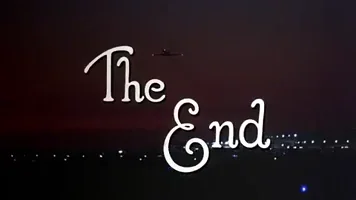